# 48V Auto-Transformer Design

In [1]:
#discription of the problem - 
#outline perhaps
#Bpeak
#Core loss
#winding loss
#add collapsible areas

In [2]:
# to do - assign permeances to core object.    also should probably assign fluxes and currents to core object

### **Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import Image, HTML, display
#from cores import PQcore

from libs.timestates import Time_states
from libs.core_geometries import EEcore
from libs.winding import Winding
import libs.core_materials as ferrite
from libs.perm_and_reluctance import Permeance_model, Reluctance_model
from libs.ac_fluxes import AC_fluxes
from libs.imag_currents import Imag_currents
from libs.dc_fluxes import DC_fluxes
from libs.flux_densities import Flux_densities
from libs.assemble_dataframes import Assemble_Dataframes

### **Time States**

In [4]:
#show 4 states
# prove winding currents are equal.....determined by charge balance in caps.

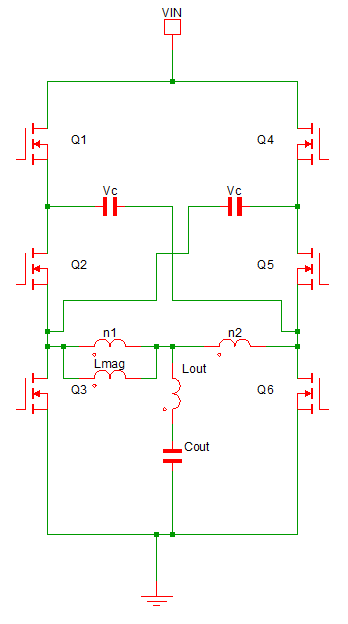

In [5]:
Image('images/div4topology_regulated.png', width=300)


### **Parameters**

#### Inputs

In [6]:
Vin  = 48
Vout = 8
iout = 25

fs   = 200e3
duty = Vout/(Vin/2)

winding_voltages = {'state1':{'center':[Vin/4,Vin/4]},
                    'state2':{'center':[0,0]},
                    'state3':{'center':[-Vin/4,-Vin/4]},
                    'state4':{'center':[0,0]}}

dc_currents = {'state1':{'center':[iout/2,iout/2]},
               'state2':{'center':[iout/2,iout/2]},
               'state3':{'center':[iout/2,iout/2]},
               'state4':{'center':[iout/2,iout/2]}}                

#### Core and Winding

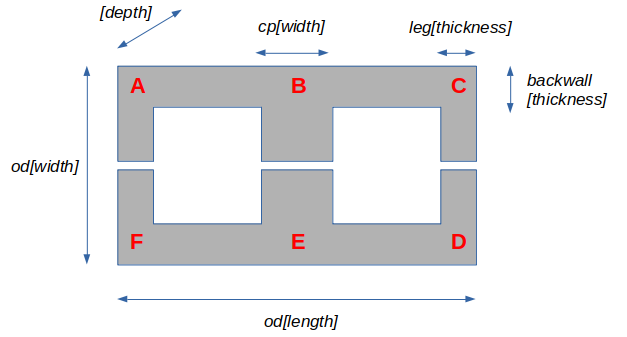

In [7]:
Image('images/ee_core_dimensions.png', width=500)

In [8]:
outerdim      = {'width':8e-3,'length':10e-3,'depth':15e-3}
backwall      = {'thickness':1.85e-3,'depth':14e-3}
leg           = {'thickness':1.85e-3,'depth':13.5e-3}
cp            = {'width':4.1e-3,'depth':11.8e-3}
gap_lengths   = {'AF':0.1e-9, 'BE':0.1e-9, 'CD':0.1e-9}
winding_turns = {'left':[0],'center':[3,3],'right':[0]}

### **Calculations**

In [9]:
pa5300_8mm     = EEcore(outerdim,backwall,leg,cp,gap_lengths)
perm           = Permeance_model(pa5300_8mm,ferrite.pc90)
windings       = Winding(turns=winding_turns)
windings.add_v_i_and_calc_dcmmfs(winding_voltages,dc_currents)
time_states    = Time_states(fs=fs,duty=duty)
acfluxes       = AC_fluxes(permeances=perm,windings=windings,time_states=time_states)
dcfluxes       = DC_fluxes(perm,windings)
fluxdensities  = Flux_densities(acfluxes,dcfluxes)
imagcurrents   = Imag_currents(acfluxes,dcfluxes)
results        = Assemble_Dataframes(fluxdensities,imagcurrents)

### **Permeance Calculations**

$\quad P=\dfrac{\mu_r\mu_0A}{l}\quad\quad R=\dfrac{1}{P}\quad\quad R_{leg}=R_c+R_g \quad\quad \dfrac{1}{P_{leg}}=\dfrac{1}{P_c}+\dfrac{1}{P_g}$

#### Combine gap and core permeances. 

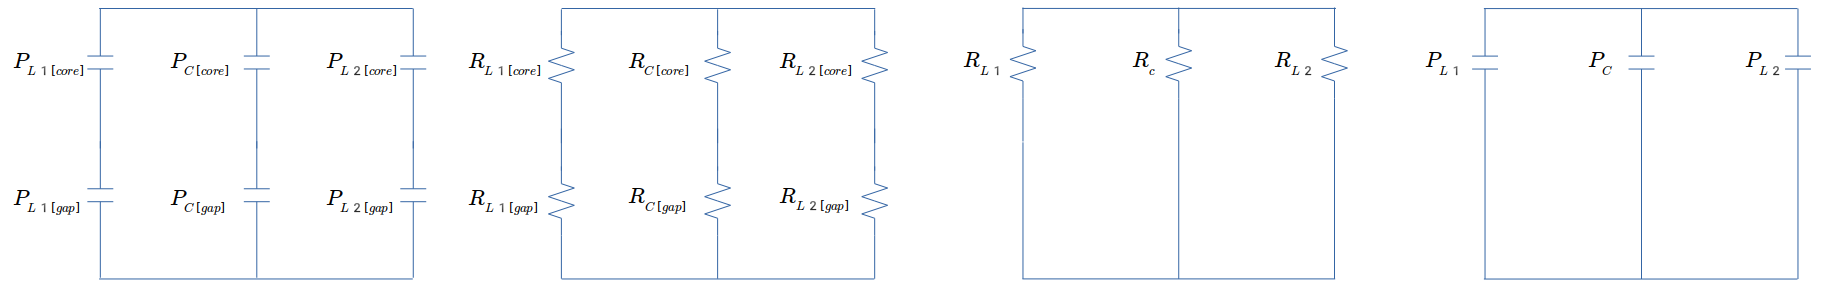

In [10]:
Image('images/permeances.png', width=1200)

### **AC fluxes and Magnetizing Inductance**

#### <span style="color:blue">*AC fluxes are voltage driven*

##### AC Fluxrate 

In [11]:
#derived using gyrator-cap model.
display(HTML("<table><tr><td><img src='images/gyrator_fluxrate_1source.png' width=400></td><td><img src='images/winding_states_xfmr.png' width=500></td><td><img src = 'images/acflux_xfmr.png' width=300></tr></table>"))


,


#### Use Faraday's Law and KCL to set up 3 equations


$\quad N_{c1}\cdot\dot\Phi_c=\dfrac{V_{phase1}-V_{phase2}}{2}\quad $ 

$\quad \dot\Phi_{L1}-\dot\Phi_c+\dot\Phi_{L2}=0$

$\quad \dot\Phi_{L1}-\dfrac{P_1}{P_2}\dot\Phi_{L2}=0$ 

#### Convert to matrix format

$\quad \begin{equation*}
\begin{pmatrix}
0 & N_{c1} & 0 \\
1 & -1 & 0 \\
0 & 0 & -\dfrac{P_1}{P_2}
\end{pmatrix}
\begin{pmatrix}
\dot\Phi_{L1} \\
\dot\Phi_c \\
\dot\Phi_{L2}
\end{pmatrix}
=
\begin{pmatrix}
\dfrac{V_{phase1}-V_{phase2}}{2} \\
0 \\
0
\end{pmatrix}
\end{equation*}$


In [12]:
results.fluxrates.set_index(['state','legs'])

Flux Rates
state  legs              
state1 left           2.0
       center         4.0
       right          2.0
state2 left           0.0
       center         0.0
       right         -0.0
state3 left          -2.0
       center        -4.0
       right         -2.0
state4 left           0.0
       center         0.0
       right         -0.0

#### AC flux

$ \quad \Delta \Phi_c = \dot\Phi_c \cdot \Delta t$

#### Combine cp and leg permeances as seen by center post winding

$\quad P_{c12}=\dfrac{P_c(P_{L1}+P_{L2})}{P_c+P_{L1}+P_{L2}}$

#### AC MMF is generated by the AC flux flowing into the permeance

$\quad \Delta F=\dfrac{\Delta \Phi_c}{\Delta P_{c12}}\quad $

#### Reflect $\Delta F$ onto center post winding1

In [13]:
#Image('deltaMMF2.png', width=200)
display(HTML("<table><tr><td><img src='images/deltaMMF2.png' width=200 height=250></td><td><img src='images/deltaMMF2_simplify.png' width=250 height=50></td><td><img src='images/deltaMMF_lmag_primary.png' width=250 height=250></td></tr></table>"))


,,


$\quad L_{mag}=N_1^2P_{c12}=N_1^2\dfrac{\Delta \Phi_c}{\Delta F_c}\quad $

In [14]:
acfluxes.Lmag

7.41e-05

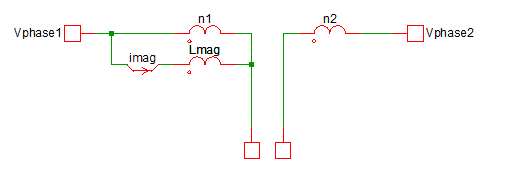

In [15]:
Image('images/imag_ac.png', width=400)

### **DC fluxes**

#### <span style="color:blue">*DC fluxes are current driven*

In [16]:
display(HTML("<table><tr><td><img src='images/winding_currents_0Adc_Imag.png' width=500></td><td><img src='images/core_I_dc.png' width=500></td><td><img src='images/mmf_dcflux.png' width=400></td></tr></table>"))


,,


#### Use KVL to set up 3 equations

$\quad F_c=F_{c1}-F_{c2}$

$\quad F_{L1}-F_c =F_{c2}-F_{c1}$

$\quad      -F_c+F_{L2} =F_{c2}-F_{c1}$

#### Convert to matrix format

$\quad \begin{equation*}
\begin{pmatrix}
0 & 1 & 0 \\
1 & -1 & 0 \\
0 & -1 & 1
\end{pmatrix}
\begin{pmatrix}
F_{L1} \\
F_c \\
F_{L2}
\end{pmatrix}
=
\begin{pmatrix}
N_1I_{c1}-N_2I_{c2} \\
N_2I_{c2}-N_1I_{c1} \\
N_2I_{c2}-N_1I_{c1}
\end{pmatrix}
\end{equation*}$


In [17]:
results.dcfluxes.set_index(['state','legs'])

DC Fluxes
state  legs             
state1 left          0.0
       center        0.0
       right         0.0
state2 left          0.0
       center        0.0
       right         0.0
state3 left          0.0
       center        0.0
       right         0.0
state4 left          0.0
       center        0.0
       right         0.0

#### In summary, $\quad F_c=F_{L1}=F_{L2}=0\quad$      and $\quad \Phi_{dc}=F\cdot P=0$

### **Flux Densities**

$\quad B_{ac}=\dfrac{\Delta\Phi}{Area}\quad\quad B_{dc}=\dfrac{\Phi_{dc}}{Area}=0$

In [18]:
results.bflat.set_index(['state','legs'])

Bac  Bdc     Bpeak
state  legs                           
state1 left    0.066733  0.0  0.033367
       center  0.068899  0.0  0.034449
       right   0.066733  0.0  0.033367
state2 left    0.000000  0.0  0.000000
       center  0.000000  0.0  0.000000
       right  -0.000000  0.0  0.000000
state3 left   -0.066733  0.0 -0.033367
       center -0.068899  0.0 -0.034449
       right  -0.066733  0.0 -0.033367
state4 left    0.000000  0.0  0.000000
       center  0.000000  0.0  0.000000
       right  -0.000000  0.0  0.000000

### **Imag currents**

$\quad I_{ac}=\dfrac{\Delta F}{N_1}\quad\quad I_{dc}=\dfrac{F}{N_1}=0$

In [19]:
results.iflat.set_index(['state','legs'])

,,Imag ac,Imag dc,Imag peak
state,legs,,,
state1,center,0.135,0.0,0.0675
state2,center,0.000,0.0,0.0000
state3,center,-0.135,0.0,-0.0675
state4,center,0.000,0.0,0.0000


### **Winding currents**

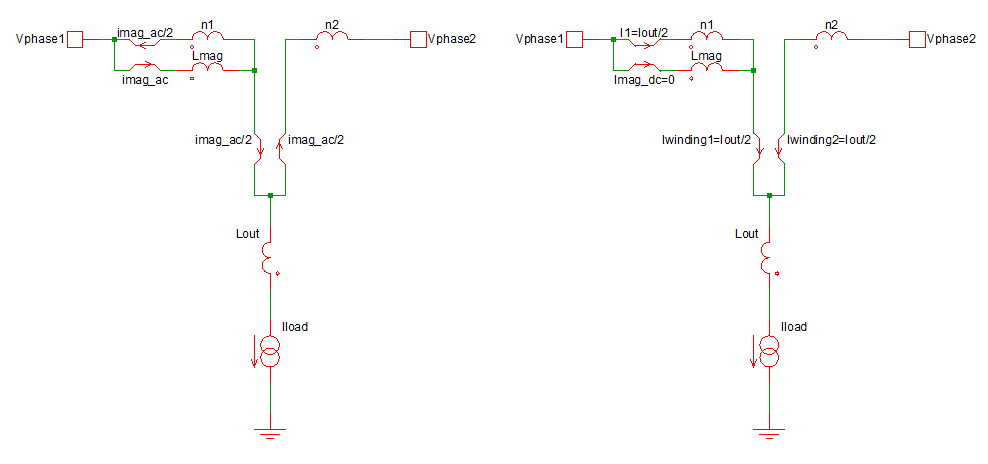

In [20]:
Image('images/winding_currents_acdc.png', width=800)

### **Core Losses**

### **Winding Losses**

# References

In [21]:
#severns - 2 papers
#cap gyrator - 3 papers